In this HW, you will finetune a stable diffusion model to enable it generate images from Naruto.

You job is to load a pretrained stable diffusion model (i.e. all its compenents: vae, unet, text encoder, text tokenizer and schedule) and then finetune it on the text-to-naruto dataset.

Finally, generate and show 10 generations. Use 5 prompts from the dataset itself and write 5 prompts yourself.

**Hints:**
- Resize the image to (512,512)
- Use appropriate data transformations and augmentations.
- If you get out of memory error, use a smaller batch size.
- You might want to use the [PNDMScheduler](https://huggingface.co/docs/diffusers/en/api/schedulers/pndm). It works better.
- At inferece time, set the training steps to 100.
- You can have a look [here](https://huggingface.co/docs/diffusers/main/en/tutorials/basic_training) and [here](https://huggingface.co/blog/stable_diffusion) to see how to do training with diffusers and use stable diffusion models.

**Disclaimer!** You cannot use the training or finetuning scripts from diffusers as it is. You have to write the code yourself. You can have a look at them though to see what needs to be done.

Finally, Stable diffusion is a large model and the Colab T4 GPU memory will not be enough. Use the following model. It's a smaller version of stable diffusion.

## Loading Model and Dataset

In [1]:
from IPython.display import clear_output

In [2]:
%pip install diffusers
clear_output()

In [3]:
model_id = "OFA-Sys/small-stable-diffusion-v0"

In [4]:
from diffusers import StableDiffusionPipeline, PNDMScheduler
from datasets import load_dataset

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torchvision import transforms

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
pipe = StableDiffusionPipeline.from_pretrained(model_id)

model_index.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/2.32G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/836 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/581 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--OFA-Sys--small-stable-diffusion-v0/snapshots/38e10e5e71e8fbf717a47a81e7543cd01c1a8140/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--OFA-Sys--small-stable-diffusion-v0/snapshots/38e10e5e71e8fbf717a47a81e7543cd01c1a8140/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
The config attributes {'predict_epsilon': True} were passed to DPMSolverMultistepScheduler, but are not expected and will be ignored. Please verify 

In [7]:
scheduler = PNDMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = scheduler

The config attributes {'predict_epsilon': True} were passed to PNDMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [8]:
# pipe = torch.nn.DataParallel(pipe, device_ids=[0, 1]).to(device)

In [9]:
transformations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

In [10]:
def preprocess_data(example):
    image = example['image']
    image = transformations(image)
    example['image'] = image
    
    return example

In [11]:
class MyDataset(Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        if transforms:
            data['image'] = self.transforms(data['image'])
        return data

In [12]:
dataset = load_dataset("lambdalabs/naruto-blip-captions")

Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/1221 [00:00<?, ? examples/s]

In [13]:
train_test_split = dataset['train'].train_test_split(test_size=0.1)

train_dataset = MyDataset(train_test_split['train'], transformations)
val_dataset = MyDataset(train_test_split['test'], transformations)

In [14]:
BATCH_SIZE = 1
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Fine-Tuning

In [15]:
unet = pipe.unet
vae = pipe.vae
text_encoder = pipe.text_encoder

vae.requires_grad_(False)
text_encoder.requires_grad_(False)
optimizer = torch.optim.AdamW(unet.parameters(), lr=5e-5)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6)

In [17]:
num_epochs = 5
accumilation_steps = 4

unet.to(device)
vae.to(device)
text_encoder.to(device)

latent_scale = 0.18215

train_losses = []
val_losses = []
learning_rates = []

def train(num_epochs):
    for epoch in range(num_epochs):
        unet.train()
        train_loss = 0

        # Training loop
        for i, batch in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", leave=False)):
            images = batch['image'].to(device)
            texts = batch['text']

            text_input = pipe.tokenizer(texts, padding="max_length", max_length=77, return_tensors="pt").input_ids.to(device)
            text_embeddings = text_encoder(text_input)[0]

            latents = vae.encode(images).latent_dist.sample()
            latents = latents * latent_scale

            noise = torch.randn(latents.shape).to(device)
            timesteps = torch.randint(0, 1000, (latents.shape[0],), device=device).long()

            noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)
            noise_pred = unet(noisy_latents, timesteps, text_embeddings).sample

            loss = torch.nn.functional.mse_loss(noise_pred, noise)
            train_loss += loss.item()

            loss = loss / accumilation_steps

            loss.backward()

            if (i + 1) % accumilation_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - Average Training Loss: {avg_train_loss:.4f}")
        train_losses.append(avg_train_loss)

        scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} - Learning Rate: {current_lr:.6f}")
        learning_rates.append(current_lr)

        # Validation loop
        unet.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}/{num_epochs}", leave=False):
                images = batch['image'].to(device)
                texts = batch['text']

                text_input = pipe.tokenizer(texts, padding="max_length", max_length=77, return_tensors="pt").input_ids.to(device)
                text_embeddings = text_encoder(text_input)[0]

                latents = vae.encode(images).latent_dist.sample()
                latents = latents * latent_scale

                noise = torch.randn(latents.shape).to(device)
                timesteps = torch.randint(0, 1000, (latents.shape[0],), device=device).long()

                noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)
                noise_pred = unet(noisy_latents, timesteps, text_embeddings).sample

                loss = torch.nn.functional.mse_loss(noise_pred, noise)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - Average Validation Loss: {avg_val_loss:.4f}\n")
        val_losses.append(avg_val_loss)

    return train_losses, val_losses, learning_rates

train(num_epochs)

Epoch 1/5 - Average Training Loss: 0.1345
Epoch 1/5 - Learning Rate: 0.000049


Epoch 1/5 - Average Validation Loss: 0.1379



Epoch 2/5 - Average Training Loss: 0.1331
Epoch 2/5 - Learning Rate: 0.000045


Epoch 2/5 - Average Validation Loss: 0.1510



Epoch 3/5 - Average Training Loss: 0.1322
Epoch 3/5 - Learning Rate: 0.000040


Epoch 3/5 - Average Validation Loss: 0.1208



Epoch 4/5 - Average Training Loss: 0.1280
Epoch 4/5 - Learning Rate: 0.000033


Epoch 4/5 - Average Validation Loss: 0.1477



Epoch 5/5 - Average Training Loss: 0.1356
Epoch 5/5 - Learning Rate: 0.000026


Epoch 5/5 - Average Validation Loss: 0.1209



([0.13449762051692657,
  0.1330697675361103,
  0.13215408195085818,
  0.12802644985989212,
  0.13563376762679455],
 [0.13794342096993412,
  0.15104803724244723,
  0.12084887603418977,
  0.147693047358662,
  0.12090600338741773],
 [4.8800884649231264e-05,
  4.532091636218621e-05,
  3.990073868116559e-05,
  3.307091636218621e-05,
  2.5500000000000003e-05])

In [25]:
train(10)

Epoch 1/10 - Average Training Loss: 0.1288
Epoch 1/10 - Learning Rate: 0.000018


Epoch 1/10 - Average Validation Loss: 0.1414



Epoch 2/10 - Average Training Loss: 0.1175
Epoch 2/10 - Learning Rate: 0.000011


Epoch 2/10 - Average Validation Loss: 0.1369



Epoch 3/10 - Average Training Loss: 0.1228
Epoch 3/10 - Learning Rate: 0.000006


Epoch 3/10 - Average Validation Loss: 0.1174



Epoch 4/10 - Average Training Loss: 0.1238
Epoch 4/10 - Learning Rate: 0.000002


Epoch 4/10 - Average Validation Loss: 0.1196



Epoch 5/10 - Average Training Loss: 0.1272
Epoch 5/10 - Learning Rate: 0.000050


Epoch 5/10 - Average Validation Loss: 0.1231



Epoch 6/10 - Average Training Loss: 0.1248
Epoch 6/10 - Learning Rate: 0.000049


Epoch 6/10 - Average Validation Loss: 0.1372



Epoch 7/10 - Average Training Loss: 0.1321
Epoch 7/10 - Learning Rate: 0.000045


Epoch 7/10 - Average Validation Loss: 0.1197



Epoch 8/10 - Average Training Loss: 0.1207
Epoch 8/10 - Learning Rate: 0.000040


Epoch 8/10 - Average Validation Loss: 0.1384



Epoch 9/10 - Average Training Loss: 0.1205
Epoch 9/10 - Learning Rate: 0.000033


Epoch 9/10 - Average Validation Loss: 0.1345



Epoch 10/10 - Average Training Loss: 0.1184
Epoch 10/10 - Learning Rate: 0.000026


Epoch 10/10 - Average Validation Loss: 0.1364



([0.13449762051692657,
  0.1330697675361103,
  0.13215408195085818,
  0.12802644985989212,
  0.13563376762679455,
  0.12878879455689218,
  0.11745464359092032,
  0.12275628115216741,
  0.12383966617314196,
  0.12717708118577134,
  0.1247850407032849,
  0.13207915208628146,
  0.12073333888920702,
  0.12047399792157347,
  0.11840113704639889],
 [0.13794342096993412,
  0.15104803724244723,
  0.12084887603418977,
  0.147693047358662,
  0.12090600338741773,
  0.1413963337171429,
  0.1369416563075066,
  0.11741845415927833,
  0.11961550191726263,
  0.12313300133417777,
  0.13722189839331175,
  0.11967646462153794,
  0.13841613459143393,
  0.13446822928120875,
  0.13635383841649787],
 [4.8800884649231264e-05,
  4.532091636218621e-05,
  3.990073868116559e-05,
  3.307091636218621e-05,
  2.5500000000000003e-05,
  1.792908363781379e-05,
  1.1099261318834413e-05,
  5.6790836378137905e-06,
  2.1991153507687385e-06,
  5e-05,
  4.8800884649231264e-05,
  4.532091636218621e-05,
  3.990073868116559e-05,

## Results

In [26]:
def plot_losses(train_losses, val_losses, learning_rates):
    fig, ax1 = plt.subplots()

    ax1.plot(train_losses, label='train loss', color='blue')
    ax1.plot(val_losses, label='val loss', color='orange')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    
    ax2 = ax1.twinx()
    ax2.plot(learning_rates, label='learning_rate', color='green')
    ax2.set_ylabel('Learning Rate', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.title('Loss and Learning Rate over Epochs')
    plt.show()


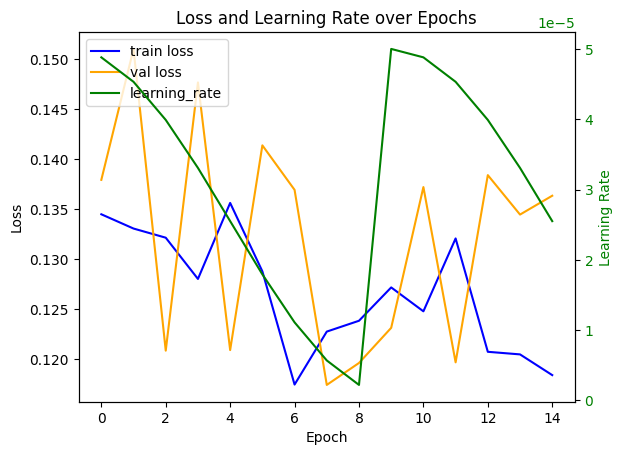

In [27]:
plot_losses(train_losses, val_losses, learning_rates)

an anime character with white hair and a black background


  0%|          | 0/100 [00:00<?, ?it/s]

a woman standing in front of a mountain


  0%|          | 0/100 [00:00<?, ?it/s]

a man with glasses and a white shirt


  0%|          | 0/100 [00:00<?, ?it/s]

a man with a sword in his hand


  0%|          | 0/100 [00:00<?, ?it/s]

a man with a gun in his hand


  0%|          | 0/100 [00:00<?, ?it/s]

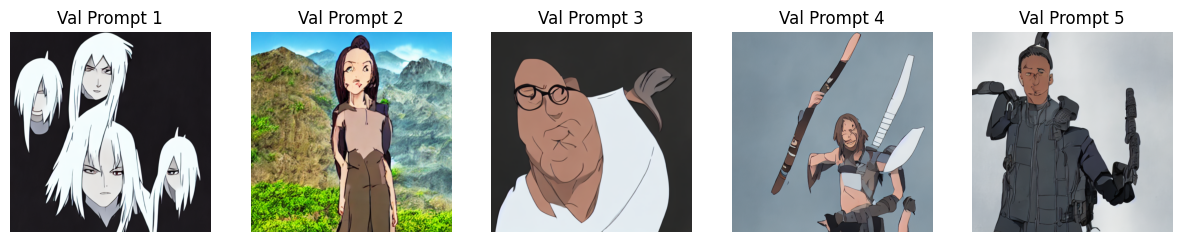

A man wearing a green shirt


  0%|          | 0/100 [00:00<?, ?it/s]

A wizard climbing a tree


  0%|          | 0/100 [00:00<?, ?it/s]

A rubber man throwing a lightning bolt


  0%|          | 0/100 [00:00<?, ?it/s]

A samurai carrying three swords


  0%|          | 0/100 [00:00<?, ?it/s]

A man shooting a slingshot


  0%|          | 0/100 [00:00<?, ?it/s]

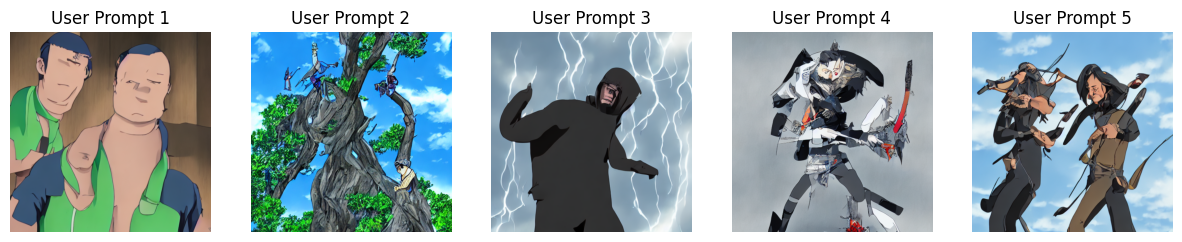

In [28]:
pipe.to(device)
pipe.safety_checker=None

def generate_images(pipeline, prompts, device):
    images = []
    for prompt in prompts:
        print(prompt)
        prompt = [prompt]
        with torch.no_grad():
            result = pipeline(prompt, num_inference_steps=100, device=device, safety_checker=None)
            images.append(result.images[0])
    return images

def get_sample_prompts(val_dataset, num_samples=5):
    prompts = []
    for i, batch in enumerate(val_dataset):
        if i >= num_samples:
            break
        prompts.append(batch['text'])
    return prompts

val_prompts = get_sample_prompts(val_dataset, num_samples=5)
val_images = generate_images(pipe, val_prompts, device)

plt.figure(figsize=(15, 10))
for i, img in enumerate(val_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Val Prompt {i+1}")
plt.show()

user_prompts = [
    "A man wearing a green shirt",
    "A wizard climbing a tree",
    "A rubber man throwing a lightning bolt",
    "A samurai carrying three swords",
    "A man shooting a slingshot"
]
user_images = generate_images(pipe, user_prompts, device)

plt.figure(figsize=(15, 10))
for i, img in enumerate(user_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"User Prompt {i+1}")
plt.show()